[@LorenaABarba](https://twitter.com/LorenaABarba)

In [42]:
# (La cellule ci-dessus exécute le style de ce bloc-note.)
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

**12 étapes vers Navier–Stokes**
=====
***

Les deux dernières étapes de ce module interactif d'enseignement commençant [CFD avec Python](https://bitbucket.org/cfdpython/cfd-python-class) résoudront toutes les deux les équations de Navier–Stokes en deux dimensions, mais avec des conditions aux limites différentes.

L'équation de quantité de mouvement sous forme vectorielle pour un champ de vitesse $\vec{v}$ est :

$$\frac{\partial \vec{v}}{\partial t}+(\vec{v}\cdot\nabla)\vec{v}=-\frac{1}{\rho}\nabla p + \nu \nabla^2\vec{v}$$

Cela représente trois équations scalaires, une pour chaque composante de vitesse $(u,v,w)$. Mais nous allons la résoudre en deux dimensions, il y aura donc deux équations scalaires.

Vous souvenez-vous de l'équation de continuité ? C'est là qu'intervient l'[équation de Poisson](./13_FR_Step_10.ipynb) pour la pression !

Étape 11: Écoulement dans une cavité avec Navier–Stokes
----
***

Voici le système d'équations différentielles : deux équations pour les composantes de vitesse $u,v$ et une équation pour la pression :

$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial x}+\nu \left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2} \right) $$


$$\frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial y}+\nu\left(\frac{\partial^2 v}{\partial x^2}+\frac{\partial^2 v}{\partial y^2}\right) $$

$$\frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2} = -\rho\left(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x}+2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}+\frac{\partial v}{\partial y}\frac{\partial v}{\partial y} \right)$$

Des étapes précédentes, nous savons déjà comment discrétiser tous ces termes. Seule la dernière équation est un peu inconnue. Mais avec un peu de patience, ce ne sera pas difficile !

### Équations discrétisées

Tout d'abord,discrétisons l'équation de conservation de la quantité de mouvement pour la composante $u$,comme suit:

$$
\begin{split}
& \frac{u_{i,j}^{n+1}-u_{i,j}^{n}}{\Delta t}+u_{i,j}^{n}\frac{u_{i,j}^{n}-u_{i-1,j}^{n}}{\Delta x}+v_{i,j}^{n}\frac{u_{i,j}^{n}-u_{i,j-1}^{n}}{\Delta y} = \\ 
& \qquad -\frac{1}{\rho}\frac{p_{i+1,j}^{n}-p_{i-1,j}^{n}}{2\Delta x}+\nu\left(\frac{u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}}{\Delta x^2}+\frac{u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}}{\Delta y^2}\right)
\end{split}
$$

De même pour la composante $v$:

$$
\begin{split}
&\frac{v_{i,j}^{n+1}-v_{i,j}^{n}}{\Delta t}+u_{i,j}^{n}\frac{v_{i,j}^{n}-v_{i-1,j}^{n}}{\Delta x}+v_{i,j}^{n}\frac{v_{i,j}^{n}-v_{i,j-1}^{n}}{\Delta y} = \\
& \qquad -\frac{1}{\rho}\frac{p_{i,j+1}^{n}-p_{i,j-1}^{n}}{2\Delta y}
+\nu\left(\frac{v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n}}{\Delta x^2}+\frac{v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n}}{\Delta y^2}\right)
\end{split}
$$

Enfin, l'équation de Poisson discrétisée peut s'écrire ainsi :

$$
\begin{split}
& \frac{p_{i+1,j}^{n}-2p_{i,j}^{n}+p_{i-1,j}^{n}}{\Delta x^2}+\frac{p_{i,j+1}^{n}-2p_{i,j}^{n}+p_{i,j-1}^{n}}{\Delta y^2} = \\
& \qquad \rho \left[ \frac{1}{\Delta t}\left(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}+\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right) -\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x} - 2\frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta x} - \frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right]
\end{split}
$$

Vous devriez écrire ces équations sur vos propres notes, à la main, en suivant mentalement chaque terme au fur et à mesure que vous l'écrivez.

Comme précédemment, réorganisons les équations de la manière dont les itérations doivent se dérouler dans le code. Tout d'abord, les équations de quantité de mouvement pour la vitesse au pas de temps suivant.

L'équation de quantité de mouvement dans la direction $u$ :

$$
\begin{split}
u_{i,j}^{n+1} = u_{i,j}^{n} & - u_{i,j}^{n} \frac{\Delta t}{\Delta x} \left(u_{i,j}^{n}-u_{i-1,j}^{n}\right) - v_{i,j}^{n} \frac{\Delta t}{\Delta y} \left(u_{i,j}^{n}-u_{i,j-1}^{n}\right) \\
& - \frac{\Delta t}{\rho 2\Delta x} \left(p_{i+1,j}^{n}-p_{i-1,j}^{n}\right) \\
& + \nu \left(\frac{\Delta t}{\Delta x^2} \left(u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}\right) + \frac{\Delta t}{\Delta y^2} \left(u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}\right)\right)
\end{split}
$$

L'équation de quantité de mouvement dans la direction $v$ :

$$
\begin{split}
v_{i,j}^{n+1} = v_{i,j}^{n} & - u_{i,j}^{n} \frac{\Delta t}{\Delta x} \left(v_{i,j}^{n}-v_{i-1,j}^{n}\right) - v_{i,j}^{n} \frac{\Delta t}{\Delta y} \left(v_{i,j}^{n}-v_{i,j-1}^{n})\right) \\
& - \frac{\Delta t}{\rho 2\Delta y} \left(p_{i,j+1}^{n}-p_{i,j-1}^{n}\right) \\
& + \nu \left(\frac{\Delta t}{\Delta x^2} \left(v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n}\right) + \frac{\Delta t}{\Delta y^2} \left(v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n}\right)\right)
\end{split}
$$

On y est presque! Maintenant, nous réorganisons l'équation Poisson en $p$ :

$$
\begin{split}
p_{i,j}^{n} = & \frac{\left(p_{i+1,j}^{n}+p_{i-1,j}^{n}\right) \Delta y^2 + \left(p_{i,j+1}^{n}+p_{i,j-1}^{n}\right) \Delta x^2}{2\left(\Delta x^2+\Delta y^2\right)} \\
& -\frac{\rho\Delta x^2\Delta y^2}{2\left(\Delta x^2+\Delta y^2\right)} \\
& \times \left[\frac{1}{\Delta t}\left(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}+\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right)-\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x} -2\frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta x}-\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right]
\end{split}
$$

La condition initiale est $u, v, p = 0$ partout, et les conditions aux limites sont :

$u=1$ at $y=2$ (le "couvercle");

$u, v=0$ sur les autres bords;

$\frac{\partial p}{\partial y}=0$ en $y=0$;

$p=0$ at $y=2$

$\frac{\partial p}{\partial x}=0$ en $x=0,2$


Mise en œuvre du flux en cavité
----


In [43]:
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [44]:
nx = 81
ny = 81
nt = 100
nit = 50
c = 1.0
dx = 2.0 / (nx - 1)
dy = 2.0 / (ny - 1)
x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)
X, Y = numpy.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx)) 
b = numpy.zeros((ny, nx))

L'équation de Poisson en pression (EPP) écrite ci-dessus peut être difficile à écrire sans fautes de frappe. La fonction `build_up_b` ci-dessous représente le contenu des crochets, de sorte que l'intégralité de l'EPP est légèrement plus gérable.

In [45]:
def build_up_b(b, rho, dt, u, v, dx, dy):
    
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return b

La fonction `pressure_poisson` est également définie pour aider à séparer les différentes séries de calculs. Notez la présence de la pseudo-variable de temps `nit`. Cette sous-itération dans le calcul de Poisson permet d'assurer un champ sans divergence.

In [46]:
def pressure_poisson(p, dx, dy, b):
    pn = numpy.empty_like(p)
    pn = p.copy()
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 en x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 en y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 en x = 0
        p[-1, :] = 0        # p = 0 en y = 2
        
    return p

Enfin, le reste des équations d'écoulement en cavité sont enveloppées dans la fonction "cavity_flow", ce qui nous permet de tracer facilement les résultats du solveur d'écoulement de cavité pour différentes durées.

In [47]:
def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = numpy.empty_like(u)
    vn = numpy.empty_like(v)
    b = numpy.zeros((ny, nx))
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    # imposer la vitesse sur le couvercle de la cavité égale à 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
        
    return u, v, p

Commençons par `nt = 100` et voyons ce que le solveur nous donne :

In [48]:
u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx))
b = numpy.zeros((ny, nx))
nt = 100
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

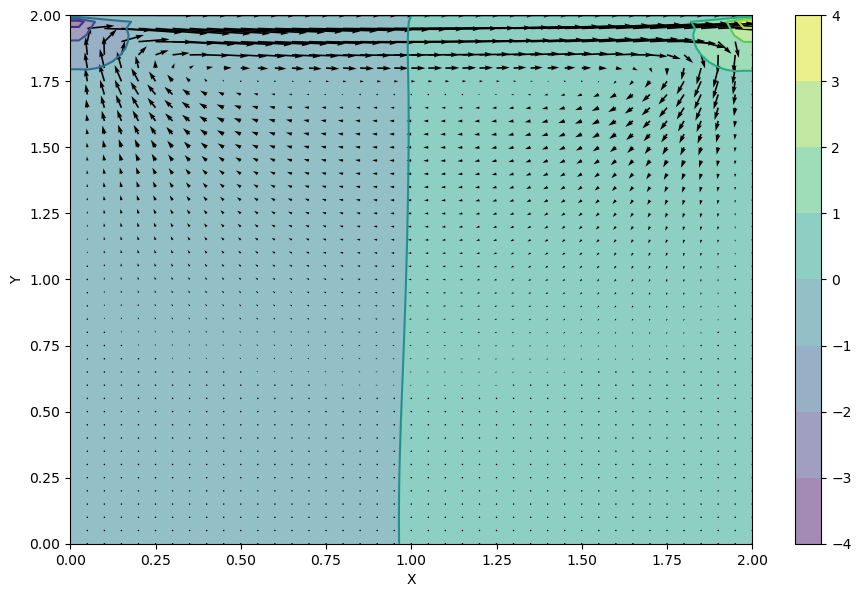

In [49]:
fig = pyplot.figure(figsize=(11,7), dpi=100)
# plotting the pressure field as a contour
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
pyplot.colorbar()
# plotting the pressure field outlines
pyplot.contour(X, Y, p, cmap=cm.viridis)  
# plotting velocity field
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
pyplot.xlabel('X')
pyplot.ylabel('Y');

Vous pouvez voir que deux zones de pression distinctes se forment et que le motif en spirale attendu de l'écoulement de la cavité entraînée par le couvercle commence à se former. Expérimentez avec différentes valeurs de `nt` pour voir combien de temps le système prend pour se stabiliser.

In [50]:
u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx))
b = numpy.zeros((ny, nx))
nt = 700
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

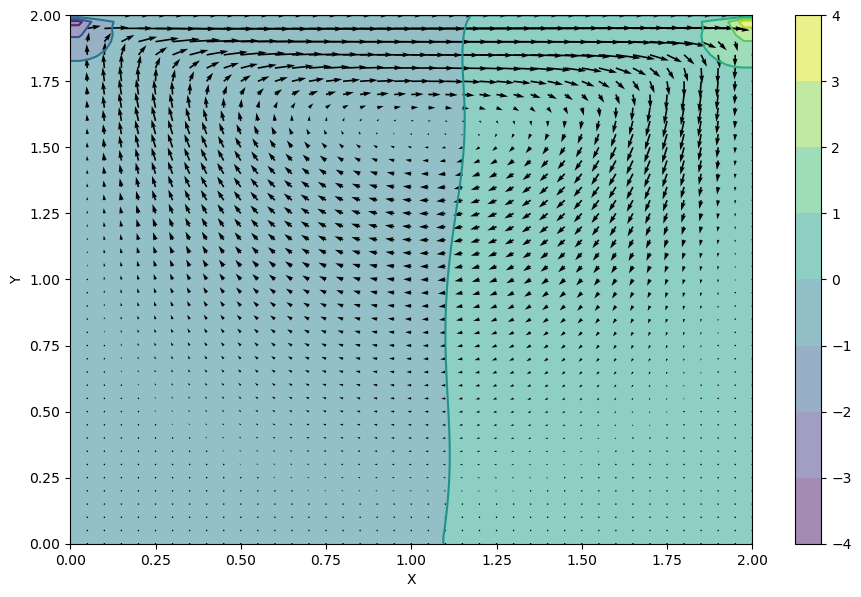

In [51]:
fig = pyplot.figure(figsize=(11, 7), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
pyplot.xlabel('X')
pyplot.ylabel('Y');

Le graphique du carquois montre l'amplitude de la vitesse aux points discrets de la grille de maillage que nous avons créée.
(En fait, nous ne montrons que la moitié des points car sinon c'est un peu le bazar. La syntaxe `X[::2, ::2]` ci-dessus est un moyen pratique de demander tous les autres points.)

Une autre façon de visualiser le flux dans la cavité consiste à utiliser un `streamplot` :

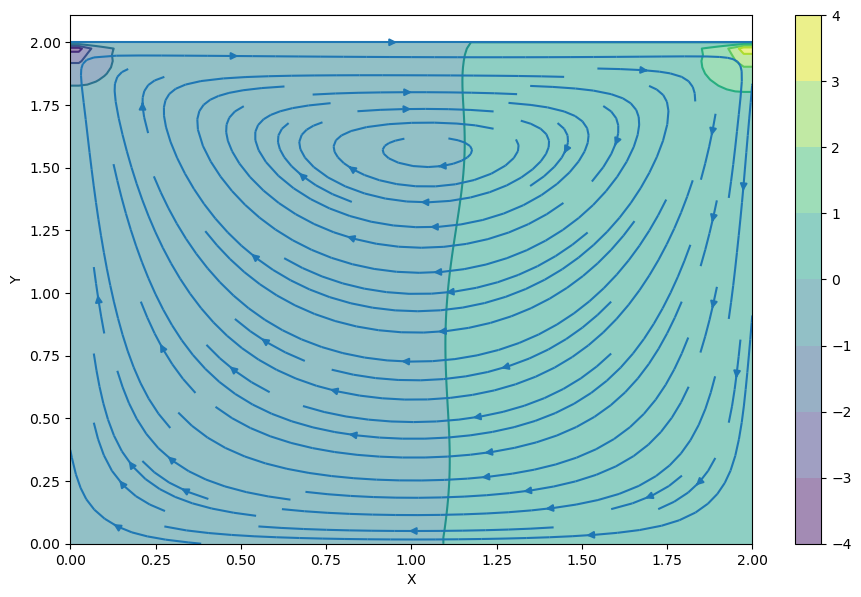

In [52]:
fig = pyplot.figure(figsize=(11, 7), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.streamplot(X, Y, u, v)
pyplot.xlabel('X')
pyplot.ylabel('Y');

##  Pour en savoir plus

Le module interactif **12 étapes vers Navier–Stokes** est l'une des nombreuses composantes du cours Computational Fluid Dynamics enseigné par le professeur Lorena A. Barba à l'Université de Boston entre 2009 et 2013.

Pour un échantillon des autres composants de ce cours, vous pouvez explorer la section **Ressources** de la version printemps 2013 du [site Piazza du cours](https://piazza.com/bu/spring2013/me702/ Ressources).